## A testing ground for the schumpeter paper

In [1]:
import numpy as np
from scipy.special import binom
import matplotlib.pyplot as plt
import networkx as nx

from typing import Optional
%matplotlib notebook

In [205]:
def generate_sigma(N: int, p_init: int) -> np.ndarray:
    """Generate the initial sigma vector with random entries of 1 and 0."""
    # return np.random.randint(0, 2, size)
    # p = p_init/N
    # return np.random.choice([0, 1], size=N, p=[1-p, p])
    p = np.zeros(N)
    p[:p_init] = np.ones(p_init)
    np.random.shuffle(p)
    return p
    

def generate_alpha(r: int, N: int) -> np.ndarray:
    """Generate the alpha tensor given a value for r such that:
        P(alpha_ijk = 1) = r/binom(N, 2)
    """
    p = r/binom(N, 2)  # probability alpha_ijk = 1
    return np.random.choice([0, 1], size=(N, N, N), p=[1-p, p])


def generate_exact_alpha(r: int, N: int) -> np.ndarray:
    """Generate the alpha tensor so that each node has exactly.
    
    Here we model an exact number of incoming destructive or productive links to a certain node.
    """
    a = np.zeros((N, N, N))
    for i in range(N):
        in_links = np.zeros(N**2)
        in_links[:r] = np.ones(r)
        np.random.shuffle(in_links)
        a[i] = in_links.reshape(N,N)
    
    return a
    

def diversity(sigma: np.ndarray, axis: Optional[int] = None) -> float:
    """Calculate the product diversity."""
    return np.mean(sigma, axis=axis)


def delta_i(sigma: np.ndarray, alpha_i: np.ndarray) -> float:
    """Calculate positive and negative influences on product i, such that:
        delta_i(sigma) = sum_{j,k} alpha_{i,j,k} * sigma_j * sigma_k
    with alpha = alpha_plus - alpha_minus.
    """
    # could also be np.einsum("jk,j,k", alpha_i, sigma, sigma)
    return sigma @ alpha_i @ sigma

def update_sigma_i(sigma: np.ndarray, i: int, delta_i: int, p: float) -> None: # -> np.ndarray:
    """Update the value of sigma at index i."""
    if delta_i > 0:
        sigma[i] = 1
    elif delta_i < 0:
        sigma[i] = 0
    
    roll = np.random.rand()
    if roll <= p:
        sigma[i] = 0 if sigma[i] == 1 else 0  # flip sigma[i]
    
    # return sigma
    
    
def progress(current: int, total: int) -> str:
    """Create a string of shape [XXX    ] depicting progress."""
    return f"[{current*'X'}{(total-current)*' '}]"

In [212]:
### TEMP #### Overwrite alpha generating function
generate_alpha = generate_exact_alpha

# config parameters
pars = {
    "N": 100,  # number of different products
    "p_init": 20,  # number of initial products
    "r_plus": 10,  # parameter defining the nonzero entries in alpha_plus
    "r_minus": 15,  # parameter defining the nonzero entries in alpha_minus
    "p": 2e-4,  # probability to flip a product state
    "T": 4000  # number of timesteps
}

sigma = generate_sigma(pars["N"], pars["p_init"])
alpha_plus = generate_alpha(pars["r_plus"],  pars["N"])
alpha_minus = generate_alpha(pars["r_minus"], pars["N"])
alpha = alpha_plus - alpha_minus

In [213]:
sigma_evolution = np.zeros((pars["T"]+1, pars["N"]))  # pre-alloc
indices = np.arange(pars["N"])
sigma_evolution[0] = sigma
show_progress_step = 10

print(progress(0, show_progress_step), end='\r')
lapcount = 0

for t in range(1, pars["T"] + 1):
    if t%(pars['T']//show_progress_step) == 0: 
        lapcount += 1
        print(progress(lapcount, show_progress_step), end='\r')
    np.random.shuffle(indices)  # random order
    for i in indices:
        d_i = delta_i(sigma, alpha[i])
        update_sigma_i(sigma, i, d_i, pars["p"])
    sigma_evolution[t] = sigma
    

<IPython.core.display.Javascript object>


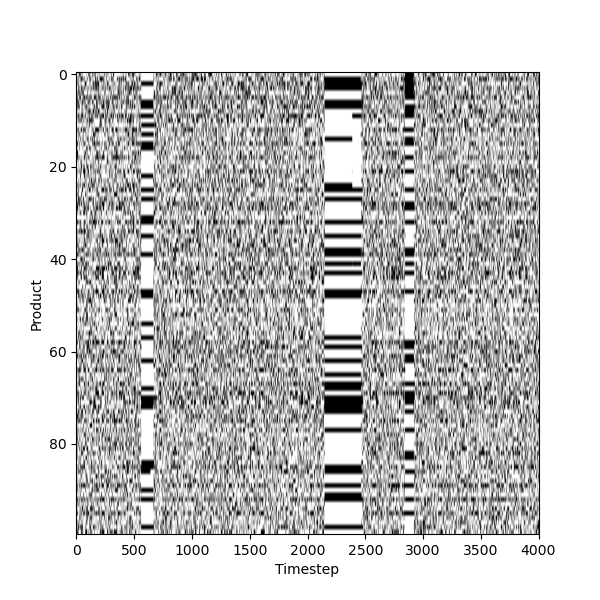

Text(0.5, 0, 'Timestep')

In [214]:
plt.figure(figsize=(6, 6))
plt.imshow(sigma_evolution.T, cmap='binary', aspect=pars['T']/pars['N'])
plt.ylabel("Product")
plt.xlabel("Timestep")
# plt.savefig("windows_in_noise_2.png", dpi=200)

<IPython.core.display.Javascript object>


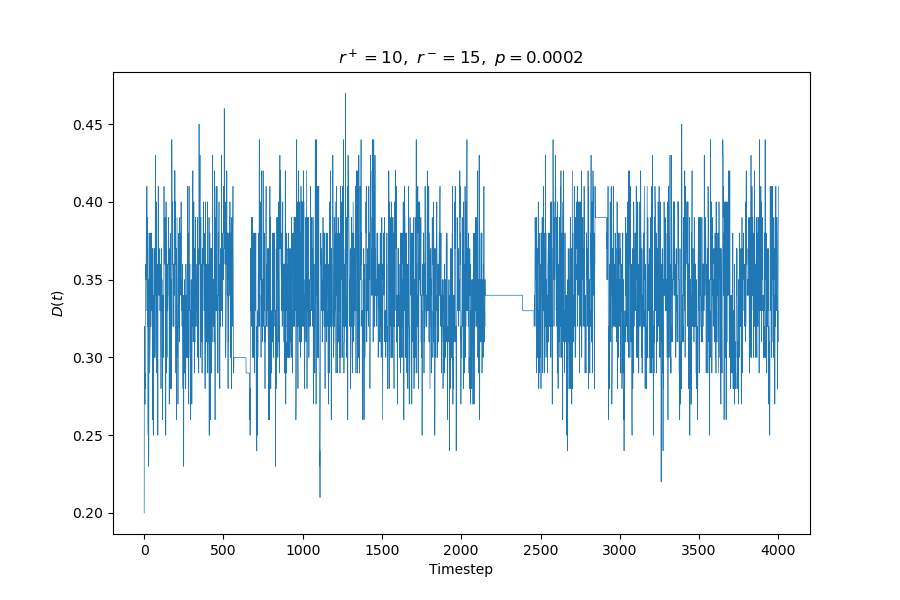

Text(0.5, 1.0, '$r^+=10,\\ r^-=15,\\ p=0.0002$')

In [215]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
ax.plot(diversity(sigma_evolution, axis=1), linewidth=0.5)
ax.set_xlabel("Timestep")
ax.set_ylabel("$D(t)$")
ax.set_title(f"$r^+={pars['r_plus']},\ r^-={pars['r_minus']},\ p={pars['p']}$")
# fig.savefig("diversity_2.png", dpi=200)

In [56]:
div = diversity(sigma_evolution, axis=1)
delta_div = div[1:] - div[:-1]

<IPython.core.display.Javascript object>


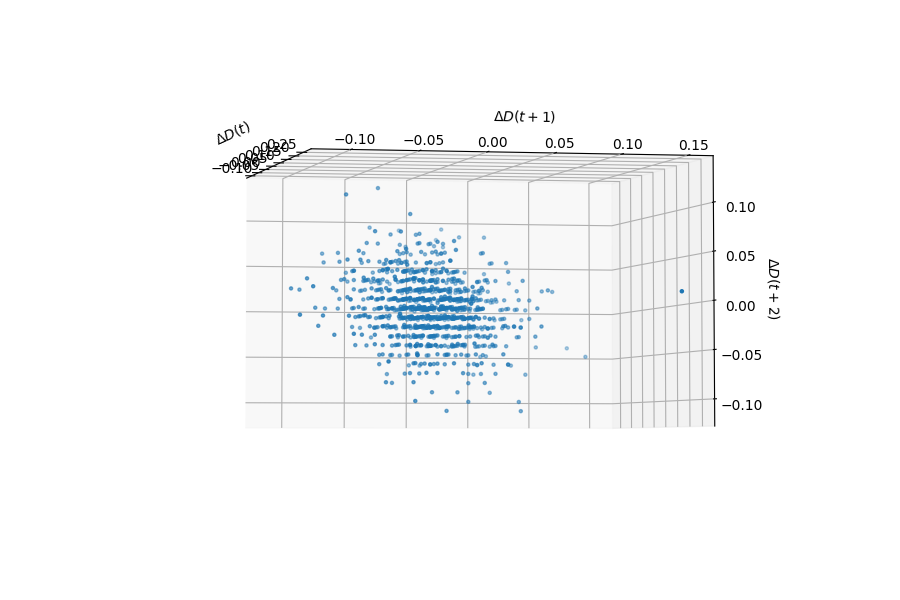

Text(0.5, 0, '$\\Delta D(t+2)$')

In [57]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=delta_div[:-2], ys=delta_div[1:-1], zs=delta_div[2:], s=5)
ax.set_xlabel("$\Delta D(t)$")
ax.set_ylabel("$\Delta D(t+1)$")
ax.set_zlabel("$\Delta D(t+2)$")